In [37]:
%%html
<style>
    table {
        display: inline-block
    }
</style>

# Black Litterman Asset Allocation Model

## Summary
The Black-Litterman asset allocation model provides a methodical way of combining investors' subjective views of the future performance of a risky investment asset with the views implied by the market equilibrium.

As a basic introduction to the model, this notebook uses two assets for allocation.  Building off this foundation, the model can be extended to N assets.

## Data

| Information Type | Details |
| :- | :- |
| Source | Yahoo Finance |
| Risk Free Rate | Treasury Yield 10 Years (^TNX) |
| Assets | Apple Share Price (AAPL) <p> Tesla Share Price (TSLA) |
| Date Range | 1 Jan 2016 to 31 Dec 2020 (5 Years) |
| Return Frequency | Monthly |

## Reference
1. https://faculty.fuqua.duke.edu/~charvey/Teaching/IntesaBci_2001/GS_The_intuition_behind.pdf
2. https://www.stat.berkeley.edu/~nolan/vigre/reports/Black-Litterman.pdf
3. https://www.mit.edu/~dbertsim/papers/Finance/Inverse%20Optimization%20-%20A%20New%20Perspective%20on%20the%20Black-Litterman%20Model.pdf
4. https://projecteuclid.org/download/pdfview_1/euclid.bj/1241444898
5. https://pyportfolioopt.readthedocs.io/en/latest/BlackLitterman.html#

## Import Libraries

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)

import sys  
sys.path.append('../src') 
from edge_risk_kit import *

import edge_risk_kit as erk

import ipywidgets as widgets
from IPython.display import display
from ipywidgets import HBox, Label, Box

In [3]:
import numpy as np
import pandas as pd
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

DATA_FOLDER = '../data/'

## Import Data

In [4]:
tickers = ['AAPL','TSLA','^TNX']

start_date = '2016-01-01'
end_date = '2020-12-31'

In [5]:
import yfinance as yf

tickerlist = []

for ticker in tickers:
    tickerinfo = {}
    tickerinfo['ticker'] = ticker
    tickerinfo['name'] = yf.Ticker(ticker).info['shortName']
    tickerinfo['marketCap'] = yf.Ticker(ticker).info['marketCap']
    tickerlist.append(tickerinfo)
    
tickerlist = pd.DataFrame(tickerlist)
tickerlist.set_index('ticker', inplace=True)

In [6]:
data = yf.download(tickers, start=start_date, end=end_date)
prices = data['Adj Close'][tickers].dropna()

[*********************100%***********************]  3 of 3 completed


In [7]:
tickerlist

,name,marketCap
ticker,,
AAPL,Apple Inc.,2.188132e+12
TSLA,"Tesla, Inc.",6.217283e+11
^TNX,CBOE Interest Rate 10 Year T No,NaN


---
## Risk Free Rate - 10 Year Treasury Yield

In [8]:
rfr = prices['^TNX']/100
print('Risk Free Rate: {:.3f}%'.format(rfr[-1]*100))

Risk Free Rate: 0.930%


In [9]:
rfr_monthly = rfr.resample('M').fillna('ffill')
rfr_monthly.index = rfr_monthly.index.to_period('M')
rfr_monthly.tail()

Date
2020-08    0.00693
2020-09    0.00677
2020-10    0.00860
2020-11    0.00844
2020-12    0.00930
Freq: M, Name: ^TNX, dtype: float64

---
## Asset Prices and Statistics

In [10]:
def calcRetsCov(px, freq):
    px_freq = px.resample(freq).fillna('ffill')
    px_freq.index = px_freq.index.to_period(freq)

    rets = px_freq.pct_change().dropna()
    cov = rets.cov()
    return rets, cov

In [11]:
to_drop = ['^TNX']
px = prices.drop(to_drop, axis=1)

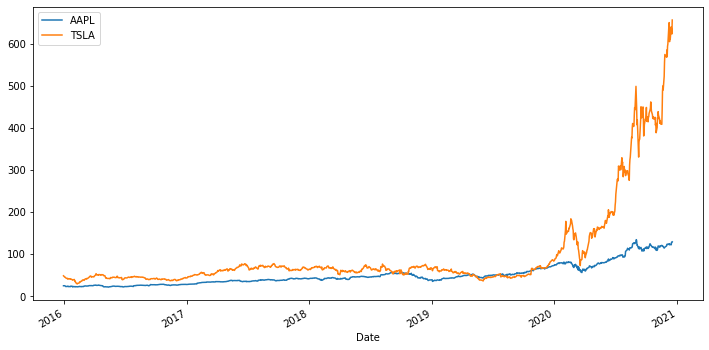

In [12]:
ax = px.plot(figsize=(12,6))
plt.show()

In [13]:
rets_monthly, cov_monthly = calcRetsCov(px, 'M')

In [14]:
rfr_period = rfr_monthly
rets_period = rets_monthly
PERIODS_PER_YEAR = 12

erk.summary_stats(rets_period, riskfree_rate=rfr_period[-1], 
                  periods_per_year=PERIODS_PER_YEAR).sort_values('Sharpe Ratio', ascending=False) \
            .style.bar(color=['pink', 'lightgreen'], align='zero')

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
AAPL,0.394789,0.300081,-0.266491,2.653517,0.116514,0.148444,1.273763,-0.304615
TSLA,0.687002,0.666086,1.223499,4.899150,0.174569,0.221356,1.008731,-0.487957


## Black Littleman Asset Allocation Model

### Procedures
1. Set the default parameters
2. Calculate the benchmark weights
3. Estimate the covariance matrix
2. Estimate the equilibrium implied returns using benchmark weights and covariance matrix
3. Set the investor's views
4. Estimate the Black-Litterman expected returns and covariance matrix
5. Calculate the optimised weights using maximum sharpe ratio using BL expected returns and convariance matrix


### Market Parameter Inputs

| Parameters | Description | Remarks |
| :- | :- | :- | 
| $w$ | A Column Vector ($N \times 1$) of Equilibrium Market Weights of the Assets | Market Cap Weights of the 2 Assets |
| $\Sigma$ | A Covariance Matrix ($N \times N$) of the Assets | Covariance Matrix of Monthly Returns between 2 Assets |
| $R_f$ | The Risk Free Rate | Latest Treasury Yield 10 Years |
| $\delta$ | The investor's Risk Aversion parameter | Default in this analysis is 2.5.  Alternatively, $\delta = \mu_M/\sigma^2_M$ |
| $\tau$ | A scalar indicating the uncertainty of the prior | Default in this analysis is 0.02.  Alternatively, $\tau = 1/T$ where $T$ is the number of periods of data used. |


### Investor Views Inputs

| Parameters | Description | Remarks |
| :- | :- | :- | 
| $Q$ | An $K \times 1$ 'Qualitative Views' or simply, Views matrix | Absolute views of an asset's expected return vs the market's implied return.  Eg: Expected return of AAPL is 3% instead of market implied return of 2%.  <p><p> Relative views of an asset's expected return vs another asset's expected return. Eg: Expected return of AAPL will overperform TSLA by 2%. |
| $P$ | A $K \times N$ 'Projection' or 'Pick' matrix, linking each view to the assets | If $Q$ is absolute view, $P$ is an identity $N$ x $N$ matrix where N is the number of assets. <p><p> If $Q$ is relative view, $P$ is a $K$ x $N$ matrix where N is the number of assets and K is the number of relative views. -1 marked for the underperforming asset, 1 marked for the overperforming asset and 0 for the rest.|
| $\Omega$ | A Covariance matrix representing the uncertainty of views | The diagonal matrix obtained from the diagonal elements of $P \tau \Sigma P^T$ |


### Implied Expected Returns at Equilibrium 

The implied returns vector $\pi$ from a set of portfolio weights $w$.

$$\pi = \delta\Sigma w$$

$w$ is usually the benchmark weights.  Market cap weights of AAPL and TSLA in our example here.

In [15]:
def implied_returns(delta, sigma, w):
    """
Obtain the implied expected returns by reverse engineering the weights
Inputs:
delta: Risk Aversion Coefficient (scalar)
sigma: Variance-Covariance Matrix (N x N) as DataFrame
    w: Portfolio weights (N x 1) as Series
Returns an N x 1 vector of Returns as Series
    """
    ir = delta * sigma.dot(w).squeeze() # to get a series from a 1-column dataframe
    ir.name = 'Implied Returns'
    return ir

### Omega matrix

The uncertaintly associated with the view in the $\Omega$ matrix, one could make the simplifying assumption that $\Omega$ is proportional to the variance of the benchmark.

$$\Omega = diag(P (\tau \Sigma) P^T) $$

In [16]:
# Assumes that Omega is proportional to the variance of the benchmark
def proportional_prior(sigma, tau, p):
    """
    Returns the He-Litterman simplified Omega
    Inputs:
    sigma: N x N Covariance Matrix as DataFrame
    tau: a scalar
    p: a K x N DataFrame linking Q and Assets
    returns a P x P DataFrame, a Matrix representing Prior Uncertainties
    """
    helit_omega = p.dot(tau * sigma).dot(p.T)
    # Make a diag matrix from the diag elements of Omega
    return pd.DataFrame(np.diag(np.diag(helit_omega.values)),index=p.index, columns=p.index)

### Black Litterman Formula

The first step of the procedure is a _reverse-optimization_ step that infers the implied returns vector $\pi$ that are implied by the equilibrium weights $w$ using the formula:

$$\pi = \delta\Sigma w$$

Next, the posterior returns and covariances are obtained from the _Black-Litterman Master Formula_ which is the following set of equations:

\begin{equation}
\label{eq:blMu}
\mu^{BL} = \pi + \tau \Sigma P^T[(P \tau \Sigma P^T) + \Omega]^{-1}[Q - P \pi]
\end{equation}

\begin{equation}
\label{eq:blSigma}
\Sigma^{BL} = \Sigma + \tau \Sigma - \tau\Sigma P^T(P \tau \Sigma P^T + \Omega)^{-1} P \tau \Sigma
\end{equation}


In [17]:
from numpy.linalg import inv

def bl(w_prior, sigma_prior, p, q,
                omega=None,
                delta=2.5, tau=.02):
    """
# Computes the posterior expected returns based on 
# the original black litterman reference model
#
# W.prior must be an N x 1 vector of weights, a Series
# Sigma.prior is an N x N covariance matrix, a DataFrame
# P must be a K x N matrix linking Q and the Assets, a DataFrame
# Q must be an K x 1 vector of views, a Series
# Omega must be a K x K matrix a DataFrame, or None
# if Omega is None, we assume it is
#    proportional to variance of the prior
# delta and tau are scalars
    """
    if omega is None:
        omega = proportional_prior(sigma_prior, tau, p)
    # Force w.prior and Q to be column vectors
    # How many assets do we have?
    N = w_prior.shape[0]
    # And how many views?
    K = q.shape[0]
    # First, reverse-engineer the weights to get pi
    pi = implied_returns(delta, sigma_prior,  w_prior)
    # Adjust (scale) Sigma by the uncertainty scaling factor
    sigma_prior_scaled = tau * sigma_prior  
    # posterior estimate of the mean, use the "Master Formula"
    # we use the versions that do not require
    # Omega to be inverted (see previous section)
    # this is easier to read if we use '@' for matrixmult instead of .dot()
    #     mu_bl = pi + sigma_prior_scaled @ p.T @ inv(p @ sigma_prior_scaled @ p.T + omega) @ (q - p @ pi)
    mu_bl = pi + sigma_prior_scaled.dot(p.T).dot(inv(p.dot(sigma_prior_scaled).dot(p.T) + omega).dot(q - p.dot(pi).values))
    # posterior estimate of uncertainty of mu.bl
#     sigma_bl = sigma_prior + sigma_prior_scaled - sigma_prior_scaled @ p.T @ inv(p @ sigma_prior_scaled @ p.T + omega) @ p @ sigma_prior_scaled
    sigma_bl = sigma_prior + sigma_prior_scaled - sigma_prior_scaled.dot(p.T).dot(inv(p.dot(sigma_prior_scaled).dot(p.T) + omega)).dot(p).dot(sigma_prior_scaled)
    return (mu_bl, sigma_bl)

### Asset Allocation using Maximum Sharpe Ratio Portfolio

The Max Sharpe Ratio (MSR) Portfolio weights are easily computed in explicit form if there are no constraints on the weights.
The weights are given by the expression:

$$ W_{MSR} = \frac{\Sigma^{-1}\mu_e}{\bf{1}^T \Sigma^{-1}\mu_e} $$

where $\mu_e$ is the vector of expected excess returns and $\Sigma$ is the variance-covariance matrix.

In [18]:
# for convenience and readability, define the inverse of a dataframe
def inverse(d):
    """
    Invert the dataframe by inverting the underlying matrix
    """
    return pd.DataFrame(inv(d.values), index=d.columns, columns=d.index)

def w_msr(sigma, mu, scale=True):
    """
    Optimal (Tangent/Max Sharpe Ratio) Portfolio weights
    by using the Markowitz Optimization Procedure
    Mu is the vector of Excess expected Returns
    Sigma must be an N x N matrix as a DataFrame and Mu a column vector as a Series
    This implements page 188 Equation 5.2.28 of
    "The econometrics of financial markets" Campbell, Lo and Mackinlay.
    """
    w = inverse(sigma).dot(mu)
    if scale:
        w = w/sum(w) # fix: this assumes all w is +ve
    return w

---
# Two Asset Portfolio Example

## Markowitz procedure

Default Parameters  
- $\delta$ = 2.5  
- $\tau$ = 0.02

Benchmark (Market Cap) Weights

In [19]:
wgts_prior = tickerlist.marketCap.dropna()/sum(tickerlist.marketCap.dropna())
pd.DataFrame(wgts_prior*100)

,marketCap
ticker,
AAPL,77.873334
TSLA,22.126666


Covariance Matrix

In [20]:
cov_monthly

,AAPL,TSLA
AAPL,0.007504,0.008589
TSLA,0.008589,0.036973


Implied returns given the benchmark wgts and covariance matrix.  Note that these values are implied monthly returns and is reasonable given that both stocks runs up significantly between 2016 and 2020.

In [21]:
DELTA = 2.5
s = cov_monthly
pi = implied_returns(delta=DELTA, sigma=s, w=wgts_prior)
pd.DataFrame(pi)

,Implied Returns
AAPL,0.019360
TSLA,0.037173


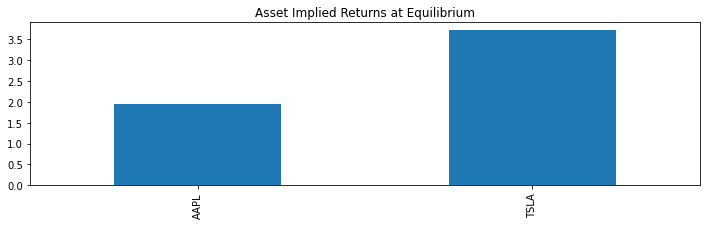

In [22]:
ax = (pi*100).plot(kind='bar', figsize=(12,3))
ax.set_title('Asset Implied Returns at Equilibrium')
plt.show()

Asset Allocation of Maximum Sharpe Ratio portfolio using implied returns and covariance matrix

In [23]:
tickers = pi.index
er_appl = pi[0]
er_tsla = pi[1]

mu_exp = pd.Series([er_appl, er_tsla], index=tickers)
msr_w = np.round(w_msr(s, mu_exp)*100, 2)
pd.DataFrame(msr_w, columns=['weights'])

,weights
AAPL,77.87
TSLA,22.13


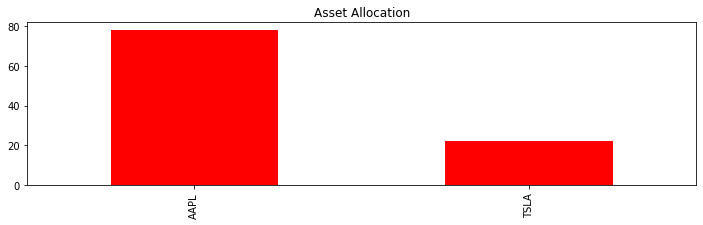

In [24]:
ax = msr_w.plot(kind='bar', color='r', figsize=(12,3))
ax.set_title('Asset Allocation')
plt.show()

### Interactive Controls

In [25]:
er1=widgets.FloatSlider(min=0, max=10, step=0.1, value=pi[0]*100, readout=True, readout_format='.2f')
er2=widgets.FloatSlider(min=0, max=10, step=0.1, value=pi[1]*100, readout=True, readout_format='.2f')
ui = widgets.HBox([Label('AAPL expected return (%)'), er1, Label('TSLA expected return (%)'), er2])

def show_native_wgts(er1, er2):
    
    tickers = pi.index

    mu_exp = pd.Series([er1, er2], index=tickers)
    msr_w = w_msr(s, mu_exp)
    
    combine_wgts = pd.concat([wgts_prior, msr_w], axis=1)
    combine_wgts = combine_wgts * 100
    combine_wgts.columns = ['bmk', 'wgts_with_views']
    ax = combine_wgts.plot(kind='bar', figsize=(12,6))
    ax.set_ylabel('Weights (%)')
    ax.set_xlabel('Assets')
    for p in ax.patches:
        ax.annotate(str(round(p.get_height(), 2)), (p.get_x() + 0.08, p.get_height() + 0.5))

### CONTROLS
combine_wgts_controls = widgets.interactive_output(show_native_wgts, {'er1':er1, 'er2':er2})    

### DISPLAY
display(combine_wgts_controls, ui)

Output()

Recall that implied returns are estimated.  Slight changes in estimation will have significant impact to the asset allocation when using the native Markowitz procedure.  The procedure generates unrealistic weights and is completely impractical.

Starting at market equilibrium, adjust to the expected returns of each asset above and see how the weight of each asset changes.  Observe that weights may reach negative at some point.

---
## Black Litterman Asset Allocation Procedure
### Recall
Equilibrium Implied Return

In [26]:
pd.DataFrame(pi)

,Implied Returns
AAPL,0.019360
TSLA,0.037173


Market Cap Weights

In [27]:
pd.DataFrame(wgts_prior*100)

,marketCap
ticker,
AAPL,77.873334
TSLA,22.126666


### Absolute View

*Example*: Assume the investor has a view that AAPL has an expected return of **1%** and TSLA has an expected return of **4%**.

In [28]:
tickers = pi.index
er_appl = 0.01
er_tsla = 0.04

q = pd.Series([er_appl, er_tsla], index=tickers)
p = pd.DataFrame(np.identity(len(q)).astype(int), columns=tickers)

In [29]:
# Find the Black Litterman Expected Returns
bl_mu, bl_sigma = bl(w_prior=wgts_prior, sigma_prior=s, p=p, q=q)

# Use the Black Litterman expected returns to get the Optimal Markowitz weights
bl_w = w_msr(bl_sigma, bl_mu)*100   

Black Litterman Asset Allocation

In [30]:
pd.DataFrame(bl_w, columns=['weights'])

,weights
AAPL,65.163743
TSLA,34.836257


The Black Litterman Asset Allocation recommends a reduction of AAPL's weight to 66.72% and increase of TSLA's weight to 33.28%.

#### Interactive Controls

In [31]:
er1=widgets.FloatSlider(min=0, max=10, step=0.1, value=pi[0]*100, readout=True, readout_format='.2f')
er2=widgets.FloatSlider(min=0, max=10, step=0.1, value=pi[1]*100, readout=True, readout_format='.2f')
ui = widgets.HBox([Label('AAPL expected return (%)'), er1, Label('TSLA expected return (%)'), er2])

def show_bl_wgts_abs_views(er1, er2):
    
    tickers = pi.index
    
    er1 /= 100
    er2 /= 100
    
    mu_exp = pd.Series([er1, er2], index=tickers)
    native_w = w_msr(s, mu_exp)
    
    q = pd.Series([er1, er2], index=tickers)
    p = pd.DataFrame(np.identity(len(q)).astype(int), columns=tickers)

    bl_mu, bl_sigma = bl(w_prior=wgts_prior, sigma_prior=s, p=p, q=q)
    bl_w = w_msr(bl_sigma, bl_mu)
    
    combine_wgts = pd.concat([wgts_prior, native_w, bl_w], axis=1)
    combine_wgts = combine_wgts * 100
    combine_wgts.columns = ['bmk', 'naive_wgts_with_views', 'bl_wgts_with_views']
    ax = combine_wgts.plot(kind='bar', figsize=(12,6))
    ax.set_ylabel('Weights (%)')
    ax.set_xlabel('Assets')
    for p in ax.patches:
        ax.annotate(str(round(p.get_height(), 2)), (p.get_x() + 0.04, p.get_height() + 0.5))

### CONTROLS
combine_wgts_controls = widgets.interactive_output(show_bl_wgts_abs_views, {'er1':er1, 'er2':er2})    

### DISPLAY
display(combine_wgts_controls, ui)

Output()

Adjust the absolute view control above to see the updated weight of each asset.  Observe the change in asset allocation against the benchmark weights based on relative view adjustments.

Note the drastic change in optimal weights when implementing with the Markowitz procedure (naive weights) when there is a slight change in expected returns.  The Markowitz procedure is highly sensitive to estimation errors in Expected Returns and Covariances.  It results in unstable portfolios with extreme weights that diverge quickly from the market equilibrium portfolio even with minor changes to the inputs.

The Black Litterman procedure is more stable.

### Relative View

In [32]:
print('With reference to the Equilibrium Implied Return, AAPL is expected ' + 
                    'to underperform TSLA by {:.2f}%.'.format((pi[1]-pi[0])*100))

With reference to the Equilibrium Implied Return, AAPL is expected to underperform TSLA by 1.78%.


*Example*: Assume the investor has a view that AAPL will overperform TSLA by **0.5%** instead

In [33]:
q = pd.Series([0.005])      ## Investor's view in magnitude
p = pd.DataFrame([
  {'AAPL': 1, 'TSLA': -1}  ## Investor's view in direction -> AAPL overperform TSLA
])

bl_mu, bl_sigma = bl(w_prior=wgts_prior, sigma_prior=s, p=p, q=q)
bl_w = w_msr(bl_sigma, bl_mu)*100   

Black Litterman Asset Allocation

In [34]:
pd.DataFrame(bl_w, columns=['weights'])

,weights
AAPL,94.493186
TSLA,5.506814


In [35]:
print('The Black Litterman Asset Allocation recommends an increase' +
      'of AAPL''s weight to {:.2f}% and reduction of TSLA''s weight to {:.2f}%.'.format(bl_w[0],bl_w[1]))

The Black Litterman Asset Allocation recommends an increaseof AAPLs weight to 94.49% and reduction of TSLAs weight to 5.51%.


#### Interactive Controls

In [36]:
rr = widgets.FloatSlider(min=-5, max=5, step=0.5, value=0, readout=True, readout_format='.2f')
ui = widgets.HBox([Label('AAPL overperform TSLA by (%)'), rr])

def show_bl_wgts_rel_views(rr):
    
    rr /= 100
    q = pd.Series([rr])
    p = pd.DataFrame([
      {'AAPL': 1, 'TSLA': -1}
    ])

    bl_mu, bl_sigma = bl(w_prior=wgts_prior, sigma_prior=s, p=p, q=q)
    bl_w = w_msr(bl_sigma, bl_mu)
    
    combine_wgts = pd.concat([wgts_prior, bl_w], axis=1)
    combine_wgts = combine_wgts * 100
    combine_wgts.columns = ['bmk', 'bl_wgts_with_views']
    ax = combine_wgts.plot(kind='bar', figsize=(12,6))
    ax.set_ylabel('Weights (%)')
    ax.set_xlabel('Assets')
    for p in ax.patches:
        ax.annotate(str(round(p.get_height(), 2)), (p.get_x() + 0.08, p.get_height() + 0.5))

### CONTROLS
combine_wgts_controls = widgets.interactive_output(show_bl_wgts_rel_views, {'rr': rr})    

### DISPLAY
display(combine_wgts_controls, ui)

Output()

Adjust the relative view control above to see the updated weight of each asset.  Observe the change in asset allocation against the benchmark weights based on relative view adjustments.

Note that when AAPL to overperform TSLA is a negative value, it is equivalent to AAPL to underperform TSLA in absolute terms.